<a href="https://colab.research.google.com/github/DanieleFoscarin/HDA2021/blob/main/Remake_ESC50_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fine tuning reference https://www.kaggle.com/sgcuber24/fine-tune-mobilenet-v2

Model choice reference https://towardsdatascience.com/how-to-choose-the-best-keras-pre-trained-model-for-image-classification-b850ca4428d4

In [ ]:
! pip install git+https://github.com/detly/gammatone.git
import gammatone

  Cloning https://github.com/detly/gammatone.git to /tmp/pip-req-build-4fb0b8q2
  Running command git clone -q https://github.com/detly/gammatone.git /tmp/pip-req-build-4fb0b8q2
     |████████████████████████████████| 163kB 16.6MB/s 
  Created wheel for Gammatone: filename=Gammatone-1.0-cp36-none-any.whl size=21795 sha256=ea7a9b4fd7031e697e52f7640b90baf922f02936ef7077a98abcbfc8cfaae375
  Stored in directory: /tmp/pip-ephem-wheel-cache-9tlpl1g_/wheels/b5/46/96/45274cda9c277d0bd423c51d5264c0326f99576fa88343fa0a
Successfully built Gammatone


In [1]:
from pathlib import Path
from scipy.io import wavfile
from IPython.display import Audio
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import librosa
from tqdm import tqdm, tqdm_notebook, notebook
import gc
import time 
import numba


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence, SequenceEnqueuer   # try enquerer that uses parallelism
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization

#import model 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [2]:
! pip install optuna --quiet
import optuna

     |████████████████████████████████| 296kB 9.1MB/s 
     |████████████████████████████████| 163kB 17.9MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 143kB 16.5MB/s 
     |████████████████████████████████| 112kB 19.9MB/s 


In [3]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

# Get Dataset

In [4]:
# Clone the entire repo.
!git clone https://github.com/karolpiczak/ESC-50.git


Cloning into 'ESC-50'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 4151 (delta 8), reused 1 (delta 0), pack-reused 4136
Receiving objects: 100% (4151/4151), 878.78 MiB | 34.63 MiB/s, done.
Resolving deltas: 100% (255/255), done.
Checking out files: 100% (2011/2011), done.


In [5]:
ROOT = '/content/ESC-50/audio'

audio_list = []
for audio in Path(ROOT).iterdir():
    try:
        sr, this_sound = wavfile.read(audio)
        audio_list.append(this_sound/32768)     #put in [-1,+1]
    except:
        print('cannot read ', str(audio))

print(len(audio_list))

print(np.shape(audio))
# audio_arr = np.array(audio_list)
# print(np.max(audio_arr), np.min(audio_arr))
#need normalization? insiede Sequence



2000
()


In [6]:
data_info = pd.read_csv("/content/ESC-50/meta/esc50.csv")
category_dict = dict(zip(data_info['target'], data_info['category']))
print(category_dict)
data_info

{0: 'dog', 14: 'chirping_birds', 36: 'vacuum_cleaner', 19: 'thunderstorm', 30: 'door_wood_knock', 34: 'can_opening', 9: 'crow', 22: 'clapping', 48: 'fireworks', 41: 'chainsaw', 47: 'airplane', 31: 'mouse_click', 17: 'pouring_water', 45: 'train', 8: 'sheep', 15: 'water_drops', 46: 'church_bells', 37: 'clock_alarm', 32: 'keyboard_typing', 16: 'wind', 25: 'footsteps', 4: 'frog', 3: 'cow', 27: 'brushing_teeth', 43: 'car_horn', 12: 'crackling_fire', 40: 'helicopter', 29: 'drinking_sipping', 10: 'rain', 7: 'insects', 26: 'laughing', 6: 'hen', 44: 'engine', 23: 'breathing', 20: 'crying_baby', 49: 'hand_saw', 24: 'coughing', 39: 'glass_breaking', 28: 'snoring', 18: 'toilet_flush', 2: 'pig', 35: 'washing_machine', 38: 'clock_tick', 21: 'sneezing', 1: 'rooster', 11: 'sea_waves', 42: 'siren', 5: 'cat', 33: 'door_wood_creaks', 13: 'crickets'}


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [ ]:
# colnames = ['filename','fold','target','category','esc10','src_file','take']
# csv = pd.read_csv('/content/ESC-50/meta/esc50.csv', header=0)
# label_list = csv.target.tolist()
# fold_list = csv.fold.tolist()
# category_list = csv.category.tolist()
# name_list = csv.filename.tolist()

# print(label_list)
# print(fold_list)

# label = np.float32(np.array(label_list))
# fold = np.float32(np.array(fold_list))
# class_dict = dict(zip(label_list, category_list))

# print(class_dict)

In [ ]:
print(audio_list[0])

[-0.01263428 -0.00698853 -0.00015259 ...  0.03915405  0.03967285
  0.03961182]


# Try first with very basic preprocessing and classification
without kfold or slicing

Save numpy files on disk in and keep using only filenames

In [7]:
! mkdir -p mel_storage
path_mel = "/content/mel_storage/"

In [8]:
def normalize01(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def melSpect(audio_list, path, n=len(audio_list)):
    mel_names = []
    for i in notebook.tqdm(range(n)):
        this_mel = librosa.amplitude_to_db(librosa.feature.melspectrogram(audio_list[i], sr=sr, n_mels=60 ))
        this_mel = normalize01(this_mel)
        this_name = str(i)+'_'+data_info['category'][i]+'.npy'
        np.save(path_mel + this_name, this_mel)
        mel_names.append(this_name)
    return mel_names

mel_names = melSpect(audio_list, path_mel)
print(np.shape(mel_names))


(2000,)


In [9]:
! mkdir -p mfcc_storage
path_mfcc = "/content/mfcc_storage/"

In [10]:
#try parallelization
#try mfcc

def normalize01(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def mfcc(audio_list, path, n=len(audio_list)):
    mfcc_names = []
    for i in notebook.tqdm(range(n)):

        #incorporate in the same func using S = mel_spectrogram for efficiency
        # this_mfcc = librosa.amplitude_to_db(librosa.feature.mfcc(audio_list[i], sr=sr, n_mfcc=60))
        this_mfcc = librosa.feature.mfcc(audio_list[i], sr=sr, n_mfcc=60)
        this_mfcc = normalize01(this_mfcc)
        this_name = str(i)+'_'+data_info['category'][i]+'.npy'
        np.save(path_mfcc + this_name, this_mfcc)
        mfcc_names.append(this_name)
    return mfcc_names

mfcc_names = mfcc(audio_list, path_mfcc)
print(np.shape(mfcc_names))


(2000,)


In [15]:
! mkdir -p chroma_storage
path_chroma = "/content/chroma_storage/"

In [19]:
def chroma(audio_list, path, n=len(audio_list)):
    chroma_names = []
    for i in notebook.tqdm(range(n)):

        #incorporate in the same func using S = mel_spectrogram for efficiency
        this_chroma = librosa.amplitude_to_db(librosa.feature.chroma_stft(audio_list[i], sr=sr, n_chroma=60))
        # this_mfcc = librosa.feature.mfcc(audio_list[i], sr=sr, n_mfcc=60)
        this_chroma = normalize01(this_chroma)
        this_name = str(i)+'_'+data_info['category'][i]+'.npy'
        np.save(path_chroma + this_name, this_chroma)
        chroma_names.append(this_name)
    return chroma_names

chroma_names = chroma(audio_list, path_chroma)
print(np.shape(chroma_names))

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning:

Trying to estimate tuning from empty frequency set.




(2000,)


Example of mel spectrogram

(60, 431)
1.0 0.0
(60, 431)
1.0 0.0
(60, 431)
1.0 0.0
(60, 431)
1.0 0.0


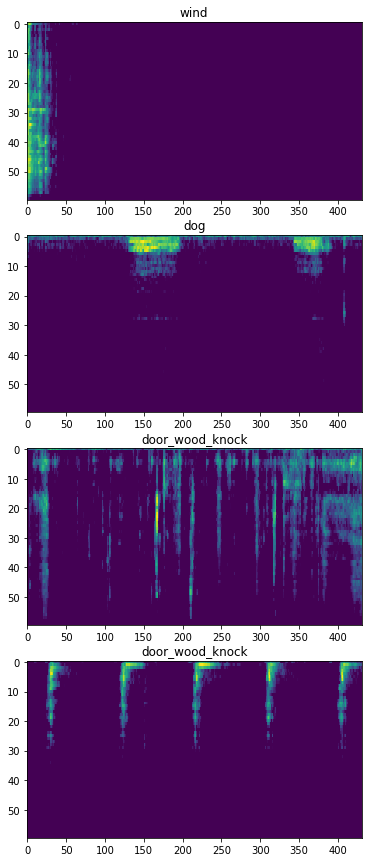

In [ ]:
fig, ax = plt.subplots(4,1,figsize=(6,15))
for i in range(4):
    sample = int(np.random.uniform()*len(audio_list))
    img = np.load(path+mel_names[sample])
    ax[i].imshow(img, interpolation='nearest', aspect='auto')
    ax[i].set_title(data_info['category'][sample])


mel, mfcc and chroma examples

1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0


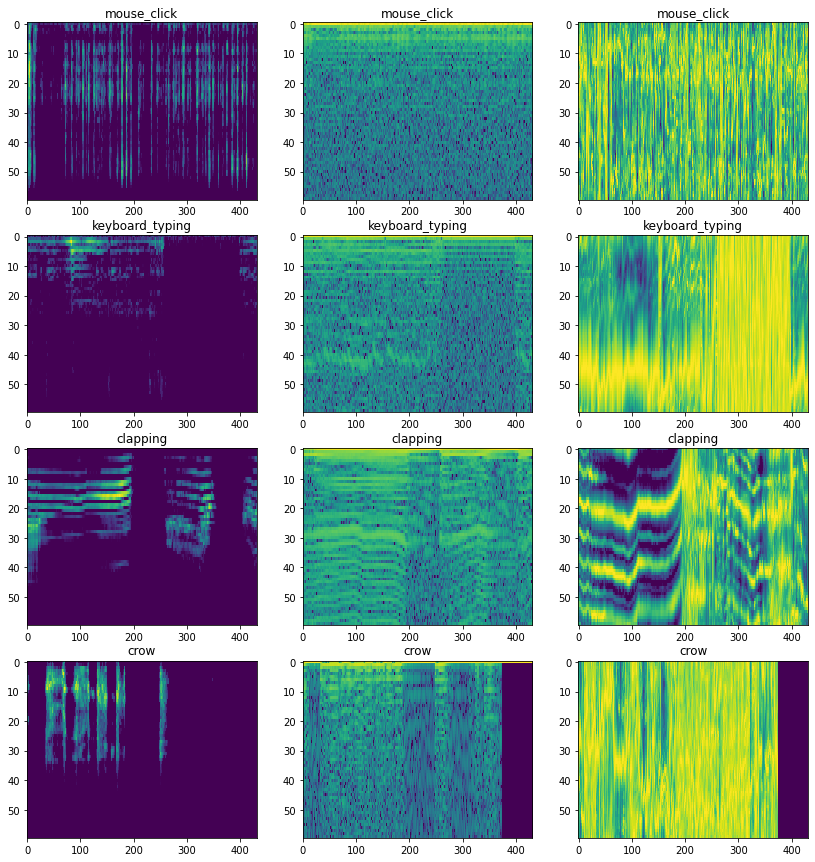

In [22]:
fig, ax = plt.subplots(4,3,figsize=(14,15))
for i in range(4):
    sample = int(np.random.uniform()*len(audio_list))

    img = np.load(path_mel + mel_names[sample])
    ax[i,0].imshow(img, interpolation='nearest', aspect='auto')
    ax[i,0].set_title(data_info['category'][sample])
    

    img = np.load(path_mfcc + mfcc_names[sample])
    ax[i,1].imshow(img, interpolation='nearest', aspect='auto')
    ax[i,1].set_title(data_info['category'][sample])
    

    img = np.load(path_chroma + chroma_names[sample])
    ax[i,2].imshow(img, interpolation='nearest', aspect='auto')
    ax[i,2].set_title(data_info['category'][sample])
    



my Dataset class, pytorch style

In [ ]:
class Dataset:
    def __init__(self, x, y):
        self.x, self.y = x, y
        if len(x)!=len(y):
            print("ERROR first and second arguments must have the same length")

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

class TripleDataset:
    def __init__(self, a, b, c, y):
        self.a, self.b, self.c = a, b, c
        self.y = y
        if len(a)!=len(y) or len(b)!=len(y) or len(b)!=len(y):
            print("ERROR the argument lists must have the same size")

     def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return [self.a[idx],self.b[idx],self.c[idx],self.y[idx]]


In [ ]:
mel_names_dataset = Dataset(mel_names, list(data_info['target']))
mfcc_names_dataset = Dataset(mfcc_names, list(data_info['target']))
chroma_names_dataset = Dataset(chroma_names, list(data_info['target'])

multi_names_dataset = Dataset = 
print(mel_names_dataset[10][0])

10_door_wood_knock.npy


make Sequence class

In [ ]:
class FileSequence(Sequence):
    # default batch size is the full dataset
    def __init__(self, dataset, path, batch_size, multi=False d3=False):
        self.dataset = dataset
        self.path = path
        self.x, self.y = self.dataset[:][0], self.dataset[:][1]
        self.batch_size = batch_size
        self.d3 =d3


    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def debug(self, idx):
        print(type(self.batch_size))
        print(type(self.x[idx*self.batch_size:(idx + 1)*self.batch_size]))

    def __getitem__(self, idx):
        batch_x = self.x[idx*self.batch_size:(idx + 1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size:(idx + 1)*self.batch_size]

        out_x = np.stack([np.load(self.path+mel_names) for mel_names in batch_x])
        
        if self.d3:
            out_x = np.stack([np.repeat(np.load(self.path+mel_names)[:,:,np.newaxis],3,axis=2) for mel_names in batch_x])
        
        return (out_x, batch_y)


In [ ]:
batch_size = 4
mel_dataloader = FileSequence(mel_names_dataset, path_mel, batch_size=batch_size)
mel_dataloader.debug(20)
print(np.shape(mel_dataloader[0][0]))
print(mel_dataloader[0][0])

<class 'int'>
<class 'list'>
(4, 60, 431)
[[[0.0357315  0.12676897 0.20065362 ... 0.         0.         0.06847536]
  [0.34207995 0.22671433 0.1339421  ... 0.14688329 0.11742473 0.09289193]
  [0.3965486  0.34452171 0.2930262  ... 0.25833218 0.31648652 0.30213701]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.27055017 0.22067904 0.13966431 ... 0.02255614 0.1

test dataloader class

500
[0, 14, 36, 36]
(60, 431)


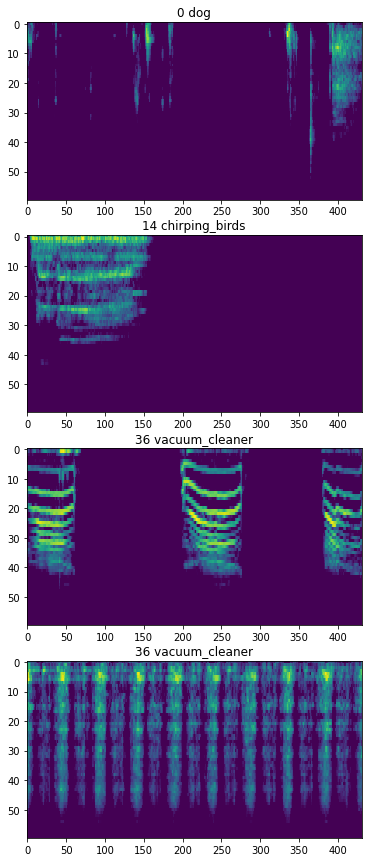

In [ ]:
batch_size = 4
mel_dataloader = FileSequence(mel_names_dataset, path_mel, batch_size=batch_size)
print(mel_dataloader.__len__())
batch_mel, batch_label = mel_dataloader[0]
print(batch_label)
print(np.shape(batch_mel[0]))

fig, ax = plt.subplots(4,1,figsize=(6,15))
for i in range(batch_size):
    ax[i].imshow(batch_mel[i], interpolation='nearest', aspect='auto')
    ax[i].set_title(str(batch_label[i])+' '+category_dict[batch_label[i]])


In [ ]:
del audio_list

In [ ]:
a = list(data_info['fold']!=5)
print(a)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

Use fold info for splitting train and validation

In [ ]:
this_fold = 5
train_idx = list(data_info['fold']!=this_fold)
val_idx = [not a for a in train_idx]
train_dataset = Dataset(np.array(mel_names_dataset[:][0])[train_idx],
                        np.array(mel_names_dataset[:][1])[train_idx])
val_dataset = Dataset(np.array(mel_names_dataset[:][0])[val_idx],
                        np.array(mel_names_dataset[:][1])[val_idx])


print(len(train_dataset))
print(len(val_dataset))

1600
400


# Model classes

In [ ]:
def basic_CNN():
    #consider 60x400x1 image
    #need to adapt from 60x431
    input = keras.Input(shape=(60,431,1))
    x = layers.Conv2D(32,   kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(input)
    x = layers.Dropout(0.2)(x)
    # x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    # x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(x) 
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(x)  
    x = layers.Dropout(0.3)(x)
    # x = layers.BatchNormalization()(x)   
    x = layers.Flatten()(x)
    x = layers.Dense(50, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    # x = layers.BatchNormalization()(x)
    x = layers.Dense(50, activation='softmax')(x)
    mel_classifier = keras.Model(input, x, name='mel_classifier')
    return mel_classifier

# #test dimensions
mel_classifier = basic_CNN()
mel_classifier.summary()
# input = np.ones((1,60,400,1))
# out = net.predict(input)
# print(np.shape(out))

Model: "mel_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 60, 431, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 216, 32)       320       
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 216, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 108, 64)       18496     
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 108, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 54, 64)         36928     
_________________________________________________________________
dropout_10 (Dropout)         (None, 8, 54, 64)      

# Training

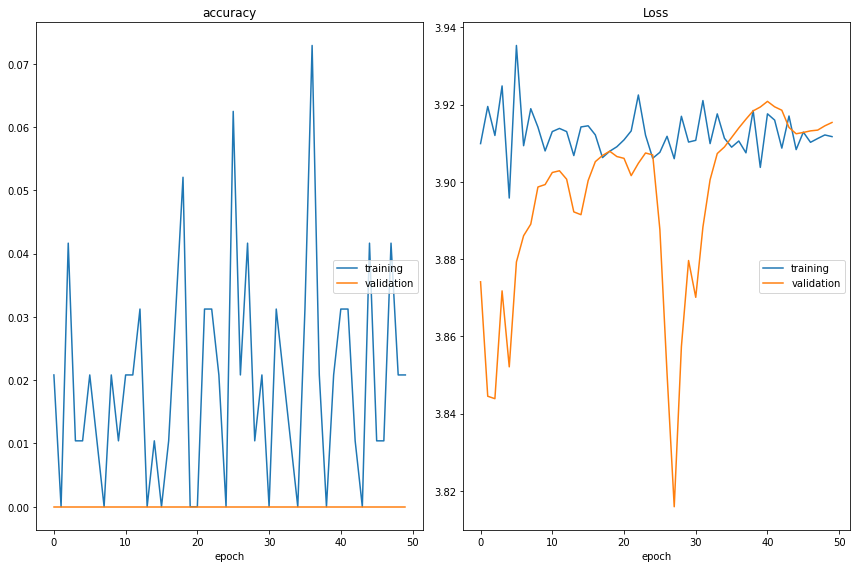

accuracy
	training         	 (min:    0.000, max:    0.073, cur:    0.021)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    3.896, max:    3.935, cur:    3.912)
	validation       	 (min:    3.816, max:    3.921, cur:    3.915)


In [ ]:
batch_size = 16
epochs = 50

train_dataloader = FileSequence(train_dataset, path_mel, batch_size)
val_dataloader =  FileSequence(val_dataset, path_mel, batch_size)

mel_classifier.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
mel_classifier.summary()


history = mel_classifier.fit(train_dataloader,
                            steps_per_epoch=int(len(train_dataloader)//batch_size),
                            epochs=epochs,
                            callbacks=[PlotLossesKeras()],
                            validation_data=val_dataloader,
                            validation_steps=int(len(val_dataloader)//batch_size),
                            verbose=0)


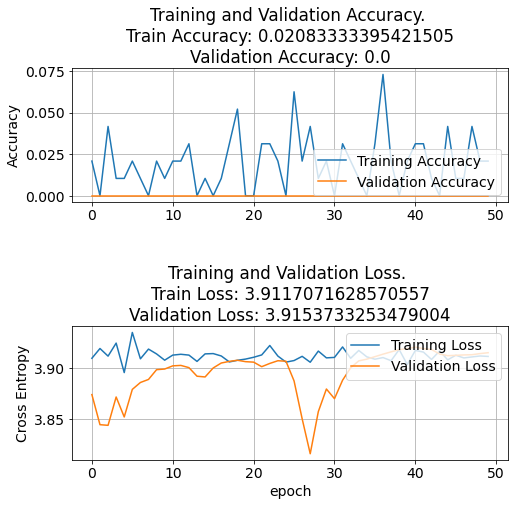

In [ ]:
#get results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'Training and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

Fine tune MobileNetV2

In [ ]:
# careful with shapes is changing data
input_shape = (60,431,3)
base_model = MobileNetV2(input_shape=input_shape,
                        input_tensor=None,                        
                        include_top=False, 
                        weights='imagenet'
                        )
base_model.trainable = True
# base_model.summary()

#define model
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(101, activation='softmax'))
#compile model
model.compile(optimizer=tf.keras.optimizers.Adam(), 
      loss = tf.keras.losses.sparse_categorical_crossentropy, 
      metrics=['accuracy'])
# print(model.summary())

training


In [ ]:
batch_size = 4
epochs = 100

train_dataloader = FileSequence(train_dataset, path_mel, batch_size, d3=True)
val_dataloader =  FileSequence(val_dataset, path_mel, batch_size, d3=True)

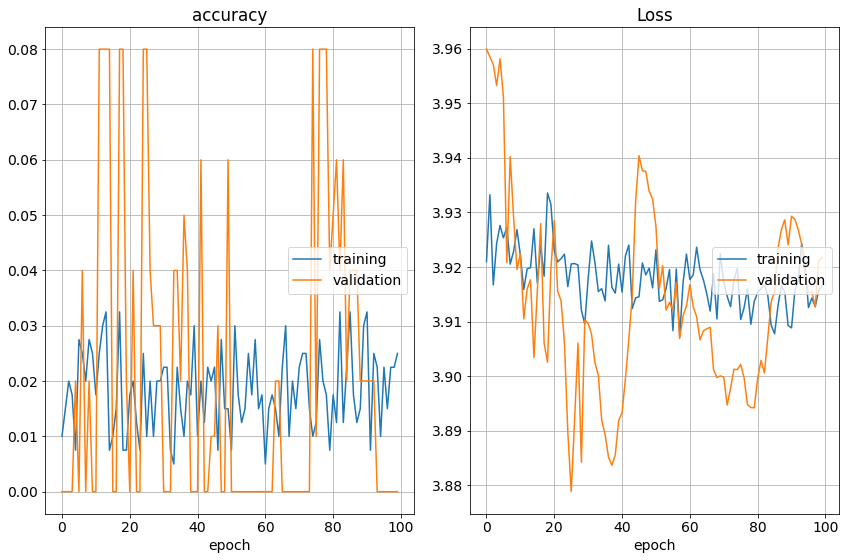

accuracy
	training         	 (min:    0.005, max:    0.032, cur:    0.025)
	validation       	 (min:    0.000, max:    0.080, cur:    0.000)
Loss
	training         	 (min:    3.907, max:    3.934, cur:    3.917)
	validation       	 (min:    3.879, max:    3.960, cur:    3.922)


In [ ]:
#fit the model
history = model.fit(train_dataloader, 
                    steps_per_epoch=int(len(train_dataloader)//batch_size),
                    epochs=epochs,
                    callbacks=[PlotLossesKeras()],
                    validation_data = val_dataloader,
                    validation_steps=int(len(val_dataloader)//batch_size),
                    )

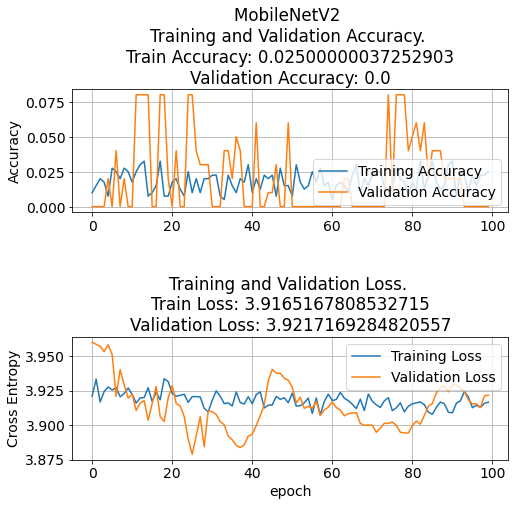

In [ ]:
#get results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'MobileNetV2 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()